# Implementing DoRA algorithm

## Creating LoRA and DoRA layers

We will be replacing the linear layers of the BERT model with the following DoRA and LoRA layers for our experiments

### LoRA Layer

In [1]:
import torch.nn as nn
import torch
import torch.nn as nn
import torch.nn.functional as F

class LoRA_layer(nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        super().__init__()
        std_dev = 1 / torch.sqrt(torch.tensor(rank).float())
        self.A = nn.Parameter(torch.randn(in_dim, rank) * std_dev)
        self.B = nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha

    def forward(self, x):
        x = self.alpha * (x @ self.A @ self.B)
        return x

Below is the implementaion of the linear layer which will replace the ones in BERT

In [2]:
class Linear_LoRA(nn.Module):

    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        self.lora = LoRA_layer(
            linear.in_features, linear.out_features, rank, alpha
        )

    def forward(self, x):
        lora = self.lora.A @ self.lora.B
        combined_weight = self.linear.weight + self.lora.alpha*lora.T
        return F.linear(x, combined_weight, self.linear.bias)


### Implement DoRA Layer

The implementation of the DoRA layer solely adapts the LoRA layer to also include teh magnitude

In [4]:
class DoRA_Linear(nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        self.linear = linear
        self.lora = LoRA_layer(
            linear.in_features, linear.out_features, rank, alpha
        )
        
        self.m = nn.Parameter(
            self.linear.weight.norm(p=2, dim=0, keepdim=True))

    def forward(self, x):
        lora = self.lora.A @ self.lora.B
        numerator = self.linear.weight + self.lora.alpha*lora.T
        denominator = numerator.norm(p=2, dim=0, keepdim=True)
        directional_component = numerator / denominator
        new_weight = self.m * directional_component
        return F.linear(x, new_weight, self.linear.bias)

Function to apply DoRA to model

In [5]:
from functools import partial

def apply_DoRA(model, rank, alpha):

    for param in model.parameters():
        param.requires_grad = False

    lora_r = rank
    lora_alpha = alpha    
    lora_query = True
    lora_key = False
    lora_value = True
    lora_projection = False
    lora_mlp = False
    lora_head = False

    layers = []

    assign_lora = partial(DoRA_Linear, rank=lora_r, alpha=lora_alpha)

    for layer in model.distilbert.transformer.layer:
        if lora_query:
            layer.attention.q_lin = assign_lora(layer.attention.q_lin)
        if lora_key:
            layer.attention.k_lin = assign_lora(layer.attention.k_lin)
        if lora_value:
            layer.attention.v_lin = assign_lora(layer.attention.v_lin)
        if lora_projection:
            layer.attention.out_lin = assign_lora(layer.attention.out_lin)
        if lora_mlp:
            layer.ffn.lin1 = assign_lora(layer.ffn.lin1)
            layer.ffn.lin2 = assign_lora(layer.ffn.lin2)
    if lora_head:
        model.pre_classifier = assign_lora(model.pre_classifier)
        model.classifier = assign_lora(model.classifier)
    
    return model

# Training Experiments

### Load Data

#### Download IMDB training data and save to csv

In [ ]:
import os
from datasets import load_dataset

import pandas as pd
import torch

# Load the IMDB dataset
imdb_dataset = load_dataset("imdb")

# Split the existing 'train' split into a new 'train' (80%) and 'validation' (20%)
train_test_split = imdb_dataset["train"].train_test_split(test_size=0.2, seed=42)

final_train_data = train_test_split["train"]
final_val_data = train_test_split["test"]  
final_test_data = imdb_dataset["test"] 

# Define the directory to save the CSVs
output_dir = "data"
os.makedirs(output_dir, exist_ok=True)

# Function to convert and save a split
def save_split_to_csv(dataset_split, name):
    # Convert Hugging Face Dataset to Pandas DataFrame
    df = pd.DataFrame(dataset_split)
    
    # Define the file path
    file_path = os.path.join(output_dir, f"{name}.csv")
    
    # Save the DataFrame to a CSV file
    df.to_csv(file_path, index=False)
    print(f"Successfully saved {name} data to: {file_path}")

# Save all three supervised splits
save_split_to_csv(final_train_data, "train")
save_split_to_csv(final_val_data, "validation")
save_split_to_csv(final_test_data, "test")


Successfully saved train data to: data\train.csv
Successfully saved validation data to: data\validation.csv
Successfully saved test data to: data\test.csv


#### Load data from csv files

In [6]:
import os
import pandas as pd
import torch

df_train = pd.read_csv(os.path.join("data", "train.csv"))
df_val = pd.read_csv(os.path.join("data", "validation.csv"))
df_test = pd.read_csv(os.path.join("data", "test.csv"))


train_texts = df_train['text']
train_labels = df_train['label']

val_texts = df_val['text']
val_labels = df_val['label']

test_texts = df_test['text']
test_labels = df_test['label']

#### Create tokenizer and Dataset Class

In [7]:
from torch.utils.data import DataLoader, Dataset
from transformers import DataCollatorWithPadding, AutoTokenizer


tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", clean_up_tokenization_spaces=True)

class IMDBDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, max_length=512, truncation=True, return_attention_mask=True, add_special_tokens=True) # Set smaller size (we know tweets are max 280 characters)
        item = {key: torch.tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item  


#### Load data into dataloaders

In [8]:
train_dataset = IMDBDataset(train_texts, train_labels, tokenizer)
val_dataset = IMDBDataset(val_texts, val_labels, tokenizer)
test_dataset = IMDBDataset(test_texts, test_labels, tokenizer)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer) # Dynamic padding of the input data for batching

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=data_collator, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=data_collator, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=data_collator, pin_memory=True)

## Train default BERT with various layer freezings

In [9]:
#define CUDA device if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Function pre-requisites

Define evaluation function

In [10]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import numpy as np

# Define evaluation function
def evaluate(model, dataloader):
    model.eval()
    losses = []
    preds = []
    true_labels = []
    for batch in dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        loss = outputs.loss
        logits = outputs.logits
        losses.append(loss.item())
        predictions = torch.argmax(logits, dim=-1)
        preds.extend(predictions.cpu().numpy())
        true_labels.extend(batch['labels'].cpu().numpy())
    avg_loss = np.mean(losses)
    accuracy = accuracy_score(true_labels, preds)
    f1 = f1_score(true_labels, preds, average='weighted')
    cm = confusion_matrix(true_labels, preds)
    cr = classification_report(true_labels, preds)
    return avg_loss, accuracy, f1, cm, cr

### Training with hyperparameter grid search

Set global variables to keep track of best model

In [11]:
# Initialize the best model and optimizer
best_val_loss_overall = float('inf')
best_val_accuracy_overall = 0

Set hyperparamters to be tested in grid search

In [12]:
# Define the sets of values for grid search
batch_sizes = [32]  # Example values for batch size
learning_rates = [1e-5]  # Example values for learning rate
scheduler_names = ['cosine']  # Example values for scheduler name
ranks = [4]

num_epochs = 20


Set the number of parameters that will be fine-tuned

Get the number of trainable parameters

In [14]:
from transformers import AutoModelForSequenceClassification

# Get number of parameters

#Init Model
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", 
    num_labels=2
)

model = apply_DoRA(model, 4, 8)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")

del model  # Delete the model to free up memory

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of trainable parameters: 82944


#### Main training loop

In [15]:
from transformers import AutoModelForSequenceClassification, AdamW, get_scheduler
from tqdm import tqdm
import time


best_config = {'dropout': None, 'batch_size': None, 'lr': None, 'wd': None, 'scheduler': None}
patience = 2
epochs_ran = 0
model_saved_at_batch = 0
num_batches_best_model = 0
lrs_best_model = []
epoch_durations = []

# Loop through hyperparameters
for rank in ranks:
    for batch_size in batch_sizes:
        for lr in learning_rates:                
            for scheduler in scheduler_names:
                print(f"Training with rank={rank}, alpha={2*rank}, batch_size={batch_size}, lr={lr}, scheduler={scheduler}")                
                print(f"Current best loss: {best_val_loss_overall}")
                print(f"Best current accuracy: {best_val_accuracy_overall}")
                print("===============================================")


                # Create DataLoaders with the current batch size
                train_loader = DataLoader(
                    train_dataset,
                    batch_size=batch_size,
                    shuffle=True,
                    collate_fn=data_collator,
                    pin_memory=True)


                # Initialize the model with the current dropout value
                model = AutoModelForSequenceClassification.from_pretrained(
                    "distilbert-base-uncased", num_labels=2
                )
                device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
                model.to(device)

                model = apply_DoRA(model, rank, (2*rank))

                for name, module in model.named_modules():
                    # Target LoRA and DoRA modules/parameters explicitly
                    if isinstance(module, (DoRA_Linear, LoRA_layer)):
                        module.to(device)
                

                # Reset Patience counter and model accuracy tracker
                patience_counter = 0
                best_model_val_loss = float('inf')
                best_model_val_accuracy = 0
                model_train_accuracies = []
                model_train_losses = []
                val_accuracies = []
                val_losses = []
                lr_values = []
                best_overall_model_found = False

                # Initialize GradScaler for AMP
                use_amp=True
                scaler = torch.amp.GradScaler(device='cuda', enabled=use_amp)

                # Initialize the optimizer and learning rate scheduler
                optimizer = AdamW(model.parameters(), lr=lr, no_deprecation_warning=True)

                num_training_steps = num_epochs * len(train_loader)
                num_warmup_steps = int(0.1 * num_training_steps)
                lr_scheduler = get_scheduler(
                    name=scheduler,
                    optimizer=optimizer,
                    num_warmup_steps=num_warmup_steps,
                    num_training_steps=num_training_steps
                )

                # Reset memory and synchronize CUDA
                torch.cuda.empty_cache()
                torch.cuda.reset_max_memory_allocated()
                torch.cuda.synchronize()


                # Start time measurement
                training_start_time = time.time()
                

                # Train loop
                for epoch in range(num_epochs):
                    epoch_start_time = time.time()
                    print(f"Epoch {epoch+1}/{num_epochs}")
                    model.train()
                    train_losses = []
                    train_preds = []
                    train_labels_epoch = []
                    progress_bar = tqdm(train_loader)
                    batch_accuracy = 0

                    for batch in progress_bar:
                        batch = {k: v.to(device) for k, v in batch.items()}

                        # Use autocast for mixed precision training
                        with torch.autocast(device_type=str(device), dtype=torch.float16, enabled=use_amp):
                            outputs = model(**batch)
                            loss = outputs.loss
                            logits = outputs.logits
                            train_losses.append(loss.item())
                            model_train_losses.append(loss.item())

                        # Backprop with GradScaler to scale gradients
                        scaler.scale(loss).backward()

                        # Update weights with scaler step
                        scaler.step(optimizer)
                        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                        scaler.update()  # Update the scaler for the next iteration

                        # Learning rate scheduler step
                        lr_scheduler.step()

                        # Get learning rate for the current batch
                        lr_values.append(optimizer.param_groups[0]['lr'])

                        optimizer.zero_grad(set_to_none=True) # set_to_none=True here can modestly improve performance

                        predictions = torch.argmax(logits, dim=-1)
                        train_preds.extend(predictions.cpu().numpy())
                        train_labels_epoch.extend(batch['labels'].cpu().numpy())

                        # Calculate accuracy for the current batch
                        correct_predictions = (predictions == batch['labels']).sum().item()
                        batch_accuracy = correct_predictions / len(batch['labels'])
                        model_train_accuracies.append(batch_accuracy)

                    # Measure epoch duration
                    epoch_end_time = time.time()
                    epoch_duration = epoch_end_time - epoch_start_time
                    epoch_durations.append(epoch_duration)
                    print(f"Epoch duration: {epoch_duration:.4f} seconds")                        
                    
                    # Measure Training performance for the epoch
                    avg_train_loss = np.mean(train_losses)
                    train_accuracy = accuracy_score(train_labels_epoch, train_preds)
                    train_f1 = f1_score(train_labels_epoch, train_preds)

                    # Evaluate the model on the validation set
                    val_loss, val_accuracy, val_f1, cm, cr = evaluate(model, val_loader)
                    val_accuracies.append(val_accuracy)
                    val_losses.append(val_loss)
                    print(f"Training Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1 Score: {train_f1:.4f}")
                    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, F1 Score: {val_f1:.4f}")
                    

                    # Update the best model if the current model is better
                    if val_loss < best_model_val_loss:
                        best_model_val_accuracy = val_accuracy
                        best_model_val_loss = val_loss
                        patience_counter = 0
                        if val_accuracy > best_val_accuracy_overall and val_loss < best_val_loss_overall:
                            best_val_loss_overall = val_loss
                            best_val_accuracy_overall = val_accuracy
                            model_saved_at_batch = (epoch+1)*len(train_loader)
                            num_batches_best_model = len(progress_bar)
                            best_config = {'rank': rank, 'alpha': (2*rank), 'batch_size': batch_size, 'lr': lr, 'scheduler': scheduler}
                            torch.save(model.state_dict(), f'best_model_DistilBERT_DoRA.pt')
                            print("===============================================")
                            print("NEW BEST MODEL FOUND")
                            print("===============================================")
                            best_overall_model_found = True

                    else:
                        patience_counter += 1
                        print(f"Patience counter: {patience_counter}")
                        if patience_counter >= patience:
                            if best_overall_model_found: # Save train accuracies and losses for the best model when early stopping
                                best_model_training_accuracies = model_train_accuracies
                                best_model_training_losses = model_train_losses
                                best_model_val_accuracies = val_accuracies
                                best_model_val_losses = val_losses
                                best_model_epoch_durations = epoch_durations
                                training_end_time = time.time()
                                total_training_time = training_end_time - training_start_time
                                epochs_ran = epoch
                                lrs_best_model = lr_values
                                print("Early stopping triggered.")
                            break
                    print("MODEL: -best loss:", best_model_val_loss, " -best accuracy:", best_model_val_accuracy)
                    print("OVERALL: -best loss:", best_val_loss_overall, " -best accuracy:", best_val_accuracy_overall)


                    # Save train accuracies and losses for the best model when all epochs are completed
                    if best_overall_model_found:                            
                        best_model_training_accuracies = model_train_accuracies
                        best_model_training_losses = model_train_losses
                        best_model_val_accuracies = val_accuracies
                        best_model_val_losses = val_losses
                        best_model_epoch_durations = epoch_durations
                        epochs_ran = epoch
                        lrs_best_model = lr_values
                        training_end_time = time.time()
                        total_training_time = training_end_time - training_start_time


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training with rank=4, alpha=8, batch_size=32, lr=1e-05, scheduler=cosine
Current best loss: inf
Best current accuracy: 0


c:\Users\Admin\anaconda3\Lib\site-packages\torch\cuda\memory.py:391: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


Epoch 1/20


100%|██████████| 625/625 [01:39<00:00,  6.31it/s]


Epoch duration: 99.0894 seconds
Training Loss: 0.6484, Accuracy: 0.6214, F1 Score: 0.6736
Validation Loss: 0.4199, Accuracy: 0.8638, F1 Score: 0.8638
NEW BEST MODEL FOUND
MODEL: -best loss: 0.41987494862498564  -best accuracy: 0.8638
OVERALL: -best loss: 0.41987494862498564  -best accuracy: 0.8638
Epoch 2/20


100%|██████████| 625/625 [01:35<00:00,  6.53it/s]


Epoch duration: 95.7002 seconds
Training Loss: 0.3430, Accuracy: 0.8704, F1 Score: 0.8699
Validation Loss: 0.2887, Accuracy: 0.8878, F1 Score: 0.8877
NEW BEST MODEL FOUND
MODEL: -best loss: 0.28865229169400736  -best accuracy: 0.8878
OVERALL: -best loss: 0.28865229169400736  -best accuracy: 0.8878
Epoch 3/20


100%|██████████| 625/625 [01:36<00:00,  6.49it/s]


Epoch duration: 96.2541 seconds
Training Loss: 0.2828, Accuracy: 0.8902, F1 Score: 0.8899
Validation Loss: 0.2657, Accuracy: 0.8924, F1 Score: 0.8924
NEW BEST MODEL FOUND
MODEL: -best loss: 0.265654273783437  -best accuracy: 0.8924
OVERALL: -best loss: 0.265654273783437  -best accuracy: 0.8924
Epoch 4/20


100%|██████████| 625/625 [01:35<00:00,  6.52it/s]


Epoch duration: 95.8912 seconds
Training Loss: 0.2601, Accuracy: 0.8996, F1 Score: 0.8996
Validation Loss: 0.2589, Accuracy: 0.8962, F1 Score: 0.8961
NEW BEST MODEL FOUND
MODEL: -best loss: 0.2588884994720879  -best accuracy: 0.8962
OVERALL: -best loss: 0.2588884994720879  -best accuracy: 0.8962
Epoch 5/20


100%|██████████| 625/625 [01:36<00:00,  6.49it/s]


Epoch duration: 96.3418 seconds
Training Loss: 0.2481, Accuracy: 0.9033, F1 Score: 0.9033
Validation Loss: 0.2582, Accuracy: 0.8980, F1 Score: 0.8979
NEW BEST MODEL FOUND
MODEL: -best loss: 0.25816961605185135  -best accuracy: 0.898
OVERALL: -best loss: 0.25816961605185135  -best accuracy: 0.898
Epoch 6/20


100%|██████████| 625/625 [01:36<00:00,  6.46it/s]


Epoch duration: 96.7081 seconds
Training Loss: 0.2354, Accuracy: 0.9095, F1 Score: 0.9094
Validation Loss: 0.2446, Accuracy: 0.9046, F1 Score: 0.9046
NEW BEST MODEL FOUND
MODEL: -best loss: 0.24458465276482388  -best accuracy: 0.9046
OVERALL: -best loss: 0.24458465276482388  -best accuracy: 0.9046
Epoch 7/20


100%|██████████| 625/625 [01:36<00:00,  6.51it/s]


Epoch duration: 96.0815 seconds
Training Loss: 0.2307, Accuracy: 0.9125, F1 Score: 0.9125
Validation Loss: 0.2455, Accuracy: 0.9028, F1 Score: 0.9027
Patience counter: 1
MODEL: -best loss: 0.24458465276482388  -best accuracy: 0.9046
OVERALL: -best loss: 0.24458465276482388  -best accuracy: 0.9046
Epoch 8/20


100%|██████████| 625/625 [01:35<00:00,  6.52it/s]


Epoch duration: 95.8843 seconds
Training Loss: 0.2258, Accuracy: 0.9144, F1 Score: 0.9143
Validation Loss: 0.2426, Accuracy: 0.9042, F1 Score: 0.9042
MODEL: -best loss: 0.24259630315743697  -best accuracy: 0.9042
OVERALL: -best loss: 0.24458465276482388  -best accuracy: 0.9046
Epoch 9/20


100%|██████████| 625/625 [01:35<00:00,  6.54it/s]


Epoch duration: 95.6110 seconds
Training Loss: 0.2161, Accuracy: 0.9193, F1 Score: 0.9192
Validation Loss: 0.2424, Accuracy: 0.9064, F1 Score: 0.9064
NEW BEST MODEL FOUND
MODEL: -best loss: 0.2424241300231923  -best accuracy: 0.9064
OVERALL: -best loss: 0.2424241300231923  -best accuracy: 0.9064
Epoch 10/20


100%|██████████| 625/625 [01:35<00:00,  6.54it/s]


Epoch duration: 95.5128 seconds
Training Loss: 0.2115, Accuracy: 0.9231, F1 Score: 0.9229
Validation Loss: 0.2402, Accuracy: 0.9058, F1 Score: 0.9058
MODEL: -best loss: 0.24019766666780645  -best accuracy: 0.9058
OVERALL: -best loss: 0.2424241300231923  -best accuracy: 0.9064
Epoch 11/20


100%|██████████| 625/625 [01:35<00:00,  6.53it/s]


Epoch duration: 95.6988 seconds
Training Loss: 0.2053, Accuracy: 0.9260, F1 Score: 0.9259
Validation Loss: 0.2399, Accuracy: 0.9056, F1 Score: 0.9056
MODEL: -best loss: 0.2399279380473085  -best accuracy: 0.9056
OVERALL: -best loss: 0.2424241300231923  -best accuracy: 0.9064
Epoch 12/20


100%|██████████| 625/625 [01:35<00:00,  6.51it/s]


Epoch duration: 95.9584 seconds
Training Loss: 0.2021, Accuracy: 0.9261, F1 Score: 0.9261
Validation Loss: 0.2392, Accuracy: 0.9070, F1 Score: 0.9070
NEW BEST MODEL FOUND
MODEL: -best loss: 0.2391547884423131  -best accuracy: 0.907
OVERALL: -best loss: 0.2391547884423131  -best accuracy: 0.907
Epoch 13/20


100%|██████████| 625/625 [01:35<00:00,  6.52it/s]


Epoch duration: 95.8117 seconds
Training Loss: 0.2007, Accuracy: 0.9282, F1 Score: 0.9282
Validation Loss: 0.2401, Accuracy: 0.9068, F1 Score: 0.9068
Patience counter: 1
MODEL: -best loss: 0.2391547884423131  -best accuracy: 0.907
OVERALL: -best loss: 0.2391547884423131  -best accuracy: 0.907
Epoch 14/20


100%|██████████| 625/625 [01:35<00:00,  6.52it/s]


Epoch duration: 95.8584 seconds
Training Loss: 0.1960, Accuracy: 0.9297, F1 Score: 0.9296
Validation Loss: 0.2403, Accuracy: 0.9064, F1 Score: 0.9064
Patience counter: 2
Early stopping triggered.


Print final results and save to file

In [16]:
print(f"Best configuration for DistilBERT with layers DoRA")
print(f"Best configuration found: Rank={best_config['rank']}, Alpha={best_config['alpha']},Batch size={best_config['batch_size']}, Learning rate={best_config['lr']}, Scheduler={best_config['scheduler']}")
print(f"Best validation accuracy: {best_val_accuracy_overall:.4f}")
print(f"Training duration: {total_training_time:.4f} seconds")
print(f"Average epoch durations: {np.mean(best_model_epoch_durations):.4f} seconds")

with open ('performances.txt', 'a') as f:
    f.write(f"Best configuration for DistilBERT with DoRA\n")
    f.write(f"Number of parameters: {num_params}\n")
    f.write(f"Best configuration found: Rank={best_config['rank']}, Alpha={best_config['alpha']},Batch size={best_config['batch_size']}, Learning rate={best_config['lr']}, Scheduler={best_config['scheduler']}")
    f.write(f"Best validation accuracy: {best_val_accuracy_overall:.4f}\n")
    f.write(f"Best validation loss: {best_val_loss_overall:.4f}\n")
    f.write(f"Training duration: {total_training_time:.4f} seconds\n")
    f.write(f"Average epoch durations: {np.mean(best_model_epoch_durations):.4f} seconds\n")
    f.write("=============================================\n")

Best configuration for DistilBERT with layers DoRA
Best configuration found: Rank=4, Alpha=8,Batch size=32, Learning rate=1e-05, Scheduler=cosine
Best validation accuracy: 0.9070
Training duration: 1674.6497 seconds
Average epoch durations: 96.1715 seconds


#### Evaluate Best Model

In [18]:
# Re-initialise BERT model
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", 
    num_labels=2  
)
model.to(device)
apply_DoRA(model, rank=best_config['rank'], alpha=best_config['alpha'])
for name, module in model.named_modules():
                    # Target LoRA and DoRA modules/parameters explicitly
                    if isinstance(module, (DoRA_Linear, LoRA_layer)):
                        module.to(device)

# Load the best model weights
model.load_state_dict(torch.load(f'best_model_DistilBERT_DoRA.pt'))

# Evaluate the model on test set
test_loss, test_accuracy, test_f1, cm, cr = evaluate(model, test_loader)
print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, F1 Score: {test_f1:.4f}")

with open ('performances.txt', 'a') as f:
    f.write(f"Test performance for DistilBERT with layers DoRA\n")
    f.write(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, F1 Score: {test_f1:.4f}\n")
    f.write(f"\nConfusion Matrix:\n{cm}\n")
    f.write(f"\nClassification Report:\n{cr}\n")
    f.write("=============================================\n\n\n")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Loss: 0.2251, Accuracy: 0.9146, F1 Score: 0.9146


### Plot training accuracies and losses

Define smoothing funciton for better visualization using exponential moving average

In [73]:
def smooth_curve_ema (data, alpha): #Uses bias correction for increased accuracy of initial values
    smoothed_data = []
    V_n = 0  
    for n, Y_n in enumerate(data, 1): 
        V_n = alpha * Y_n + (1 - alpha) * V_n
        correction_factor = 1 - (1 - alpha)**n
        corrected_EMA = V_n / correction_factor
        smoothed_data.append(corrected_EMA)
    return smoothed_data

In [74]:
# Smoothing factor between 0 and 1 for EMA smoothing for acc and loss plots
alpha = 0.01

Plot training and validation accuracy

In [75]:
print(epochs_ran)
print(len(best_model_val_accuracies))
print(best_model_val_accuracies[0])
print(best_model_val_accuracies[1])

8
9
0.8764
0.901


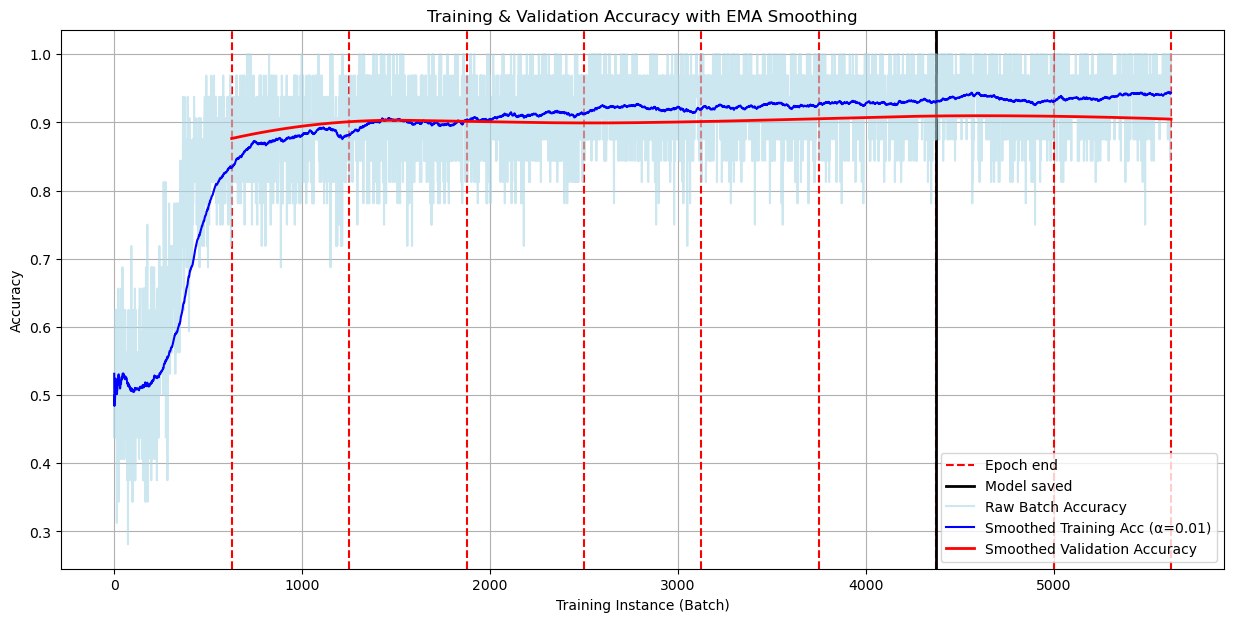

In [76]:
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, interp1d

plt.figure(figsize=(15, 7))

#------------- Plot where epochs end -------------#
for i in range(1, epochs_ran + 2):
    if i == 1:
        plt.axvline(x=i * num_batches_best_model, color='r', linestyle='--', label='Epoch end')
    else:
        plt.axvline(x=i * num_batches_best_model, color='r', linestyle='--')
plt.axvline(x=model_saved_at_batch, color='black', label='Model saved', linewidth=2) # Plot where the model was saved


#------------- Plot the training accuracies ------------#
plt.plot(best_model_training_accuracies, 
         label='Raw Batch Accuracy', 
         color='lightblue', 
         alpha=0.6) # Reduced opacity for the background noise

#Plot smoothed training accuracies
smoothed_accuracies = smooth_curve_ema(best_model_training_accuracies, alpha)
plt.plot(smoothed_accuracies, 
         label=f'Smoothed Training Acc (α={alpha})', 
         color='blue', 
         linewidth=1.5)


#------------ Plot validation accuracies --------------#
val_x = np.array([i * num_batches_best_model for i in range(1, epochs_ran +2)]) 
val_y = np.array(best_model_val_accuracies)

# Interpolate some points for a smooth curve for validation acc, currently we only have one measure per epoch
val_x_smooth = np.linspace(val_x.min(), val_x.max(), 300) # Create 300 new points
interp_func = interp1d(val_x, val_y, kind='quadratic') # Use cubic for a smooth fit
val_y_smooth = interp_func(val_x_smooth)

plt.plot(val_x_smooth, 
         val_y_smooth, 
         color='red', 
         label='Smoothed Validation Accuracy', 
         linewidth=2)


# ------------- Finalize plot and save plot --------------#
plt.xlabel(f'Training Instance (Batch)')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy with EMA Smoothing')
plt.legend()
plt.grid(True)
plt.savefig(f'acc_for_best_model_DoRA.png')
plt.show()

Plot Training and Validation Loss

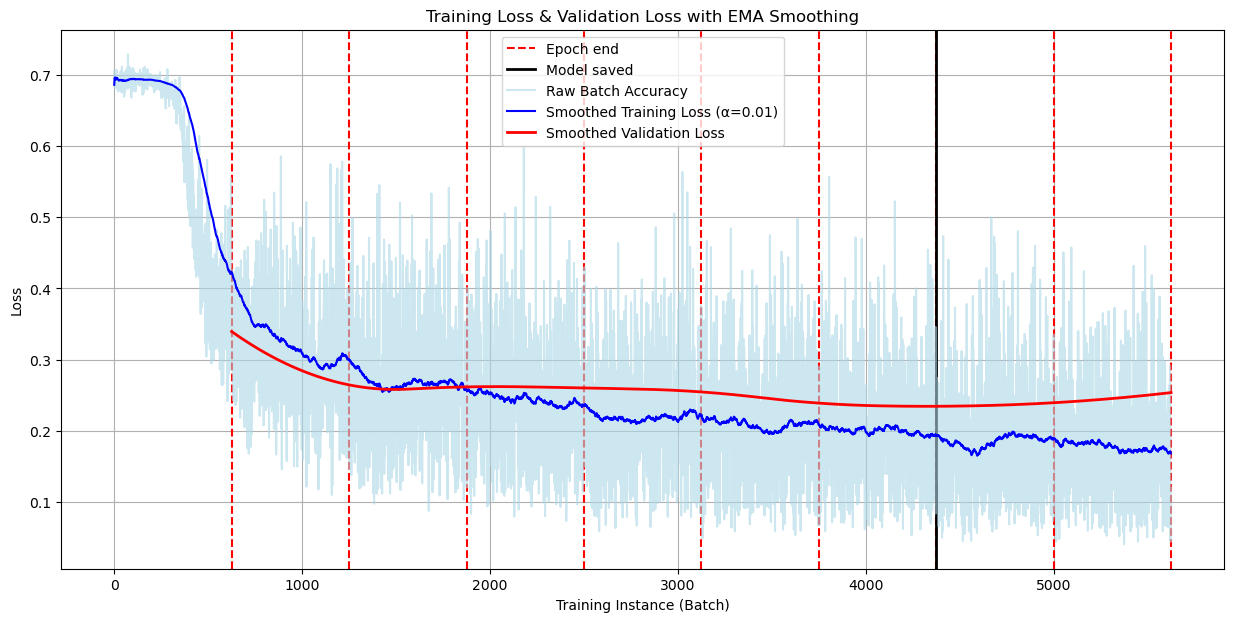

In [77]:
plt.figure(figsize=(15, 7))

#------------- Plot where epochs end -------------#
for i in range(1, epochs_ran + 2):
    if i == 1:
        plt.axvline(x=i * num_batches_best_model, color='r', linestyle='--', label='Epoch end')
    else:
        plt.axvline(x=i * num_batches_best_model, color='r', linestyle='--')
plt.axvline(x=model_saved_at_batch, color='black', label='Model saved', linewidth=2) # Plot where the model was saved


#------------ Plot the training losses -------------#
plt.plot(best_model_training_losses, 
         label='Raw Batch Accuracy', 
         color='lightblue', 
         alpha=0.6) # Reduced opacity for the background noise

#Plot smoothed training losses
smoothed_losses = smooth_curve_ema(best_model_training_losses, alpha)
plt.plot(smoothed_losses, 
         label=f'Smoothed Training Loss (α={alpha})', 
         color='blue', 
         linewidth=1.5)


#------------- Plot validation losses --------------#
loss_x = np.array([i * num_batches_best_model for i in range(1, epochs_ran + 2)])
loss_y = np.array(best_model_val_losses)

# Interpolate some points for a smooth curve for validation loss, currently we only have one measure per epoch
loss_x_smooth = np.linspace(loss_x.min(), loss_x.max(), 300) #
interp_func_loss = interp1d(loss_x, loss_y, kind='quadratic') # Use cubic for a smooth fit
loss_y_smooth = interp_func_loss(loss_x_smooth)

plt.plot(loss_x_smooth, 
         loss_y_smooth, 
         color='red', 
         label='Smoothed Validation Loss', 
         linewidth=2)


# ------------- Finalize plot and save plot --------------#
plt.xlabel(f'Training Instance (Batch)')
plt.ylabel('Loss')
plt.title('Training Loss & Validation Loss with EMA Smoothing')
plt.legend()
plt.grid(True)
plt.savefig(f'loss_for_best_model_DoRA.png')
plt.show()


Plot merged accuracy and losses (smnoothed)

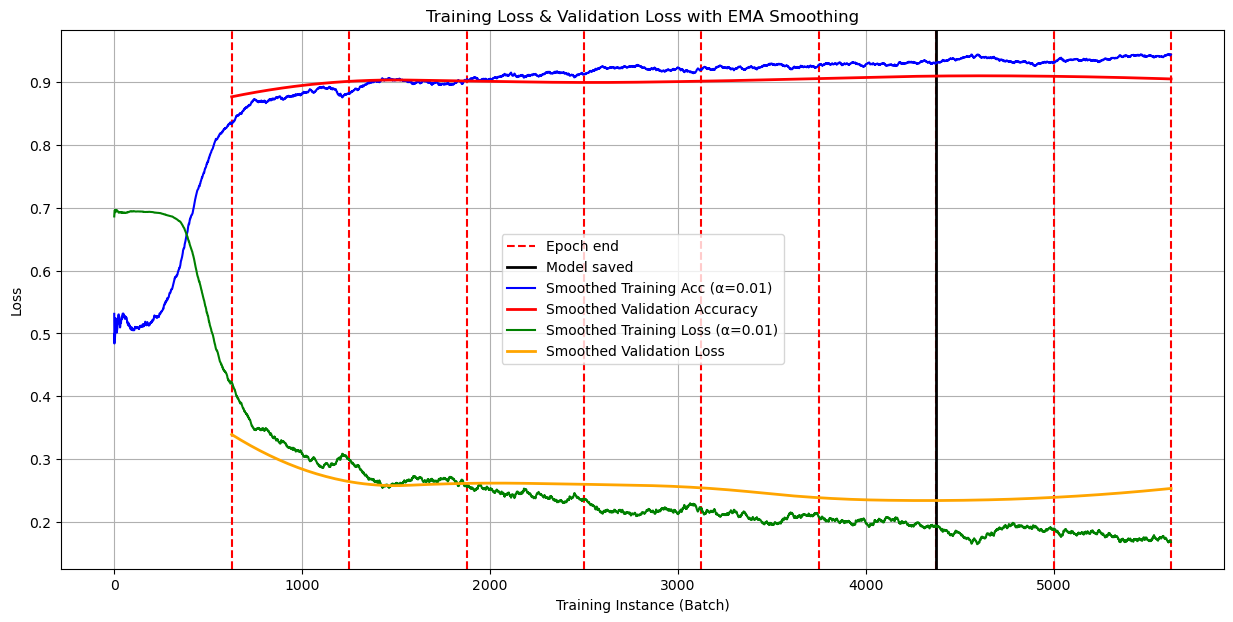

In [78]:
plt.figure(figsize=(15, 7))

#------------- Plot where epochs end -------------#
for i in range(1, epochs_ran + 2):
    if i == 1:
        plt.axvline(x=i * num_batches_best_model, color='r', linestyle='--', label='Epoch end')
    else:
        plt.axvline(x=i * num_batches_best_model, color='r', linestyle='--')
plt.axvline(x=model_saved_at_batch, color='black', label='Model saved', linewidth=2) # Plot where the model was saved


#------------- Plot the smoothed accuracies ------------#
smoothed_accuracies = smooth_curve_ema(best_model_training_accuracies, alpha)
plt.plot(smoothed_accuracies, 
         label=f'Smoothed Training Acc (α={alpha})', 
         color='blue', 
         linewidth=1.5)


#------------ Plot validation accuracies --------------#
val_x = np.array([i * num_batches_best_model for i in range(1, epochs_ran + 2)]) 
val_y = np.array(best_model_val_accuracies)

# Interpolate some points for a smooth curve for validation acc, currently we only have one measure per epoch
val_x_smooth = np.linspace(val_x.min(), val_x.max(), 300) # Create 300 new points
interp_func = interp1d(val_x, val_y, kind='quadratic') # Use cubic for a smooth fit
val_y_smooth = interp_func(val_x_smooth)

plt.plot(val_x_smooth, 
         val_y_smooth, 
         color='red', 
         label='Smoothed Validation Accuracy', 
         linewidth=2)


#-------------- Plot smoothed losses -------------#
smoothed_losses = smooth_curve_ema(best_model_training_losses, alpha)
plt.plot(smoothed_losses, 
         label=f'Smoothed Training Loss (α={alpha})', 
         color='green', 
         linewidth=1.5)


#------------- Plot validation losses --------------#
loss_x = np.array([i * num_batches_best_model for i in range(1, epochs_ran + 2)])
loss_y = np.array(best_model_val_losses)

# Interpolate some points for a smooth curve for validation loss, currently we only have one measure per epoch
loss_x_smooth = np.linspace(loss_x.min(), loss_x.max(), 300) #
interp_func_loss = interp1d(loss_x, loss_y, kind='quadratic') # Use cubic for a smooth fit
loss_y_smooth = interp_func_loss(loss_x_smooth)

plt.plot(loss_x_smooth, 
         loss_y_smooth, 
         color='orange', 
         label='Smoothed Validation Loss', 
         linewidth=2)


# ------------- Finalize plot and save plot --------------#
plt.xlabel(f'Training Instance (Batch)')
plt.ylabel('Loss')
plt.title('Training Loss & Validation Loss with EMA Smoothing')
plt.legend()
plt.grid(True)
plt.savefig(f'acc_loss_for_best_model_DoRA.png')
plt.show()
